In [1]:
pip install tabulate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from random import seed
from random import randrange
import seaborn as sns
from tabulate import tabulate

### Lectura y procesamiento de datos

In [2]:
# Lectura de datos
data = sns.load_dataset('iris')
data.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


A continuación se ajustará la categoría a clasificar, la cual será setosa contra el resto.

In [3]:
# Cambiar ajuste de datos para clasificar setosa
data['categoria'] = [1 if x =='setosa' else -1 for x in data['species']] 

### Máquinas de soporte vectorial (SVM) utilizando el método de descenso por gradiente

In [4]:
# Función clasifica
def clasifica(x, y, theta, theta_0):
    """ DEF: Evalúa la predicción de la categoría en base al modelo (theta, theta_0)
    Inputs:
    x: vector de caracteristicas
    y: vector de etiquetas
    theta: vector
    theta_0: escalar
    Outputs:
    value: -1 si la clasific es incorrecta, 0 si lo es
    """
    
    # Regla de clasificación
    z = y*(np.dot(theta,np.transpose(x)) + theta_0)
    if z < 1 :
        value = -1
    else:
        value = 0

    return value

In [5]:
def loess(x, y, theta, theta_0):
    """ DEF: Evaluación en la función de perdida
    Inputs:
    x: vector de características
    y: vector de etiquetas
    theta: vector normal del hiperplano
    theta_0: nivel base del hiperplano (pseudo-ordenada al origen)
    Outputs:
    suma = valor de pérdida  
    """
    
    suma = 0
    H = 0
    n = x.shape[0]
    
    for i in range(n):
        H = y[i]*(np.dot(theta, x[i]) + theta_0)
        if H >= 1:
            suma += 0
        else:
            suma += (1-H)
            
    return suma

In [6]:
def jacob(X, Y, theta, theta_0, lamb):
    """ DEF: Cálculo del jacobiano
    Inputs:
    X: matriz de características
    Y: vector de etiquetas
    theta: vector normal del hiperplano
    theta_0: nivel base del hiperplano (pseudo-ordenada al origen)
    lamb: escalar que indica la tasa de aprendizaje
    Outputs:
    value = valor del jacobiano
    """
    
    n = X.shape[0]
    jacobiano = loess(X, Y, theta, theta_0)/n + (lamb/2.0)*np.linalg.norm(theta)

    return jacobiano

In [7]:
# Función para descenso por gradiente
def SVM(X, Y, theta, theta_0, etha, lamb, eps = 1e-8, MAX = 3000):
    """ DEF: Máquina de soporte vectorial en base al método descenso en gradiente
    Inputs:
    X: matriz de características
    Y: vector de etiquetas
    theta: vector normal del hiperplano
    theta_0: nivel base del hiperplano (pseudo-ordenada al origen)
    lamb: escalar que indica la tasa de aprendizaje
    Outputs:
    theta = hiperplano final
    theta_0 = base del hiperplano final (pseudo-ordenada al origen)
    """
    
    n = X.shape[0]
    sum_theta = 0
    sum_theta_0 = 0
    error = 10
    t = 0
    
    # Salir del ciclo si alcanzamos la tolerencia deseada o bien porque se llegó al máximo de iteraciones permitidas
    while error >= eps and t < MAX:
        # Guardar parametros en tiempo: t-1
        theta_old = theta
        theta_0_old = theta_0
        
        # Evaluacion de la suma para la actualizacion el descenso por gradiente
        for i in range(n):
            sum_theta += clasifica(X[i], Y[i], theta, theta_0)*Y[i]*X[i]
            sum_theta_0 += clasifica(X[i], Y[i], theta, theta_0)*Y[i]
        
        # Descenso por gradiente
        theta = theta - etha*((sum_theta/n) + lamb*theta)
        theta_0= theta_0 - etha*((sum_theta_0/n))
        
        # Calculo del error
        error = abs(jacob(X, Y, theta, theta_0, lamb) - jacob(X, Y, theta_old, theta_0_old, lamb))
        t += 1
    
    jac = jacob(X, Y, theta, theta_0, lamb)
    return theta, theta_0

In [8]:
def CV_SVM(D, k, theta, theta_0, etha, lamb):
    """ DEF: Computa la validación cruzada para determinar la lambda que minimiza el error
    Inputs:
    D:matriz de características
    k:número de subconjutos a probar
    theta: vector normal del hiperplano
    theta_0: nivel base del hiperplano (pseudo-ordenada al origen)
    etha: escalar
    lamb: escalar que indica la tasa de aprendizaje

    Outputs:
    error_promedio: error promedio de cada clasificación
    """
    
    errors = []
    n = D.shape[0]
    
    # Calculo del tamaño de los bloques
    n = int((n / k))
    
    for i in range (0,k):
        init = n*i
        fin = n*(i+1)
        # Selecionar datos del i-esimo bloque para prueba y entrenamiento
        test_i = D.iloc[init:fin,:]
        train_i = D.drop(test_i.index)
        X_train = train_i.iloc[:,0:4]
        X_train = X_train.to_numpy()
        Y_train = train_i.iloc[:,5]
        Y_train = Y_train.to_numpy()
        # Obtener el i-esimo hiperplano utilizando metodología de descenso por gradiente
        theta,theta_0 = SVM(X = X_train, Y = Y_train, theta = theta , theta_0 = theta_0, etha = etha, lamb = lamb)
        X_test = test_i.iloc[:,0:4]
        X_test = X_test.to_numpy()
        Y_test = test_i.iloc[:,5]
        Y_test = Y_test.to_numpy()
        # Calculo del i-esimo error
        error_i = error(X = X_test, Y = Y_test, theta = theta, theta_0 = theta_0)
        errors.append(error_i)
    
    error_promedio = np.mean(errors)

    return error_promedio

In [9]:
def error(X, Y, theta, theta_0):
    """ DEF: Cómputo del error en base al modelo definido por el hiperplano theta y theta_0
    Inputs:
    X: vector de caracteristicas
    Y: vector de clases
    theta: vector normal del hiperplano
    theta_0: nivel base del hiperplano (pseudo-ordenada al origen)    
    Outputs:
    error_prom: error promedio de datos mal clasificadas
    """
    
    n = len(X)
    suma = 0
    error_prom = 0
    X = np.squeeze(np.asarray(X))
    Y = np.squeeze(np.asarray(Y))
    
    for i in np.arange(n):
        clasificador = Y[i]*((np.dot(theta,X[i])) + theta_0)
        # Regla de clasificación correcta
        if clasificador <= 0:
            suma += 1         
    error_prom += suma
    
    error_prom = error_prom/n
    return error_prom

### Descenso por gradiente estocástico (SGD)

In [10]:
def SGD(X, Y, lamb, T = 3000):
    """ DEF: Cómputo de vector normal del hiperplano separador en base a metodología descenso por gradiente estocástico
    Inputs:
    X: matriz de caracteristicas
    Y: matriz de etiquetas
    T: máximo de iteraciones
    lamb: Párametro lambda 
    Outputs:
    theta_t: parámetros del hiperparámetro obtenido por el método
    """
    
    n = X.shape[0]
    X = np.matrix(X)
    ones = np.matrix(np.ones((X.shape[0],1)))
    X = np.append(X, ones, axis=1)
    Y = np.matrix(Y).reshape(Y.shape[0],1)
    theta_t = np.matrix(np.zeros(X.shape[1]))
    
    for t in range(T):
        # Seleccionar observación de manera aleatoria
        i = np.random.randint(n)
        etha = 1/(t+1)
        theta_t = np.squeeze(np.asarray(theta_t))
        x_i = np.squeeze(np.asarray(X[i]))
        # Regla de ajuste por método de descenso por gradiente estocástico
        if np.dot(theta_t,x_i)*Y[i] < 1:
            l_h =  -1
        else:
            l_h =  0
        # Ajuste del hiperparámetro
        theta_t = theta_t - etha*(l_h*Y[i]*x_i + (lamb)*theta_t)
        
    return np.array(theta_t)

In [11]:
def CV_SGD(D, k, lamb):
    """ DEF: Computa la validación cruzada para determinar la lambda que minimiza el error
    Inputs:
    D: matriz de características
    k: número de subconjutos a probar
    Outputs:
    error_promedio: error promedio de cada clasificación
    """
    
    errors = []
    n = D.shape[0]
    # Calculo del tamaño de los bloques
    n = int((n / k))
    
    for i in range (0,k):
        init = n*i
        fin = n*(1+i)
        # Selecionar datos del i-esimo bloque para prueba y entrenamiento
        test_i = D.iloc[init:fin,:]
        train_i = D.drop(test_i.index)
        # Obtener el i-esimo hiperplano utilizando metodología de descenso por gradiente estocástico
        X = train_i.iloc[:,0:4]
        Y = train_i.iloc[:,5]
        theta_t = SGD(X = X, Y = Y, lamb = lamb)
        theta = theta_t[0,0:-1]
        theta_0 = theta_t[0,-1]
        # Calculo del i-esimo error
        X = test_i.iloc[:,0:4]
        Y = test_i.iloc[:,5]
        e_i = error(X = X, Y = Y, theta = theta, theta_0 = theta_0)
        errors.append(e_i)
    
    error_promedio = np.mean(errors)

    return error_promedio

### Prueba del algoritmo: descenso por gradiente estocástico (SGD)

Separación de datos para prueba y entrenamiento

In [12]:
# Separar datos para prueba y entrenamiento
np.random.seed(2020)
train = data.sample(frac = 0.8, random_state = 2020) # Fijamos la semilla con random_state
test = data.drop(train.index)

# Extraer variables para la clasificación
data_vars = train.iloc[:,0:4]
vars_train = data_vars.to_numpy()
data_labels = train.iloc[:,5]
labels_train = data_labels.to_numpy()

test_vars = test.iloc[:,0:4]
vars_test = test_vars.to_numpy()
test_labels = test.iloc[:,5]
labels_test = test_labels.to_numpy()

Cómputo de $\lambda$ óptima en base al data de entrenamiento

In [19]:
error_sgd = []
lambdas = [1e-4, 1e-3, 1e-2,  1e-1,  1]
for lamb in lambdas:
    error_sgd.append(CV_SGD(D = train, k = 5, lamb = lamb))
print(error_sgd)

[0.0, 0.0, 0.0, 0.0, 0.0]


Para cualquier $\lambda \in \{ 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 1\}$ el error es $0$, por convención se utilizará $\lambda = 10^{-3}.$

A continuación se muestran los resultados de función predefinida `SGD`:

In [39]:
np.random.seed(2020)
theta_t = SGD(X = train.iloc[:,0:4], Y = train.iloc[:,5], lamb = 0.001, T=1000)
theta_SGD = theta_t[0,0:-1]
theta_0_SGD = theta_t[0,-1]
print('Parámetros del hiperplano SGD: ', theta_SGD)
print('Pseudo-ordenada al origen SGD: ', theta_0_SGD)
error_SGD = error(vars_test, labels_test, theta_SGD, theta_0_SGD)
print('Error de método SGD: ', error_SGD)

Parámetros del hiperplano SGD:  [ 0.74724692  1.71755737 -2.87446804 -1.1700243 ]
Pseudo-ordenada al origen SGD:  0.23579375290931415
Error de método SGD:  0.0


### Prueba del algoritmo: descenso por gradiente (SVM)

In [20]:
# Separar datos para prueba y entrenamiento
np.random.seed(2020)
train = data.sample(frac = 0.8, random_state = 2020) # Fijamos la semilla con random_state
test = data.drop(train.index)

# Extraer variables para la clasificación
data_vars = train.iloc[:,0:4]
vars_train = data_vars.to_numpy()
data_labels = train.iloc[:,5]
labels_train = data_labels.to_numpy()

test_vars = test.iloc[:,0:4]
vars_test = test_vars.to_numpy()
test_labels = test.iloc[:,5]
labels_test = test_labels.to_numpy()

# Parámetros de inicio
theta = np.array([0.0, 0.0, 0.0, 0.0])
theta_0 = 0.0
etha = 0.0001

In [21]:
error_SVM=[]
lambdas = [1e-4, 1e-3, 1e-2,  1e-1,  1]
for lamb in lambdas:
    error_SVM.append(CV_SVM(D = train, k = 5, theta = theta, theta_0 = theta_0, etha = etha, lamb = lamb))
print(error_SVM)

[0.0, 0.0, 0.0, 0.0, 0.008333333333333333]


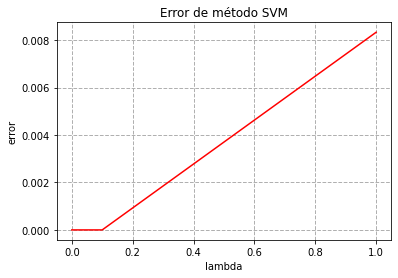

In [36]:
plt.plot(lambdas, error_SVM, color = 'red')
plt.title('Error de método SVM')
plt.xlabel('lambda')
plt.ylabel('error')
#plt.grid()
plt.grid(linestyle='--', linewidth=1)
plt.show()

A continuación se muestran los resultados de función predefinida `SVM`:

In [41]:
theta_SVM, theta_0_SVM = SVM(X = vars_train, Y = labels_train, 
                             theta = np.array([0.0, 0.0, 0.0, 0.0]), theta_0 = np.array([0.0]),
                             etha = 1e-4, lamb = 1e-4)
print('Parámetros del hiperplano SVM: ', theta_SVM)
print('Pseudo-ordenada al origen SVM: ', theta_0_SVM)
error_SVM = error(vars_test, labels_test, theta_SVM, theta_0_SVM)
print('Error de método SVM: ', error_SVM)
print('Jacobiano evaluado en parámetros óptimos SVM: ', jacob(X = vars_train, Y = labels_train, 
                                                          theta = theta_SVM, theta_0 = theta_0_SVM, lamb = 1e-3))

Parámetros del hiperplano SVM:  [  8.34218174  20.85576294 -31.01597078 -14.73339556]
Pseudo-ordenada al origen SVM:  [4.19432833]
Error de método SVM:  0.0
Jacobiano evaluado en parámetros óptimos SVM:  0.02051595861769767


### Prueba del algoritmo: perceptrón

-- BRAULIO: AQUI VA TU CÓDIGO, PUEDES CHECAR EL FORMATO QUE LE DI A LAS GRÁFICAS Y FUNCIONES PARA QUE LAS TOMES COMO BASE Y TENER EL MISMO TIPO


-- POR ÚLTIMO: NO OLVIDES AGREGAR LOS RESULTADOS DEL PERCEPTRON (THETHA_0, THETA Y ERROR A LA SIGUIENE TABLA)

In [ ]:
print(tabulate([['SGD', theta_SVM, theta_0_SVM, error_SVM], ['SVM', theta_SGD, theta_0_SGD, error_SGD]], 
               headers=['Método', 'theta', 'theta_0', 'Error']))